# Análisis de Variabilidad de TSM y CHLA en el Pacífico Colombiano (1981–2018)

Este cuaderno tiene como objetivo explorar y analizar la **variabilidad espacial y temporal** de la **temperatura superficial del mar (TSM)** y la **clorofila (CHLA)** en función de los eventos climáticos del **ENSO** (*El Niño*, *La Niña* y *Neutro*), desde septiembre de 1981 hasta octubre de 2018.

Se aplican análisis estadísticos, pruebas no paramétricas y visualizaciones interactivas para identificar patrones de respuesta en diferentes estaciones geográficas y temporadas climáticas.

El análisis incluye:

- Estadísticas por evento ENSO
- Variabilidad mensual y estacional
- Comparaciones entre estaciones
- Mapas interactivos de TSM y CHLA
- Evaluación de la variabilidad por estación



In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point
from unidecode import unidecode
from scipy import stats
from scipy.stats import zscore, kruskal, shapiro
import folium
from folium.features import DivIcon
import scikit_posthocs as sp

## Carga y Preparación de Datos

En esta sección, vamos a:

1. **Cargar los archivos de datos**:  
   - TSM (Temperatura Superficial del Mar)  
   - CHLA (Clorofila)  
   - Coordenadas de estaciones

2. **Unificar los datos en un solo DataFrame** combinando TSM y CHLA mediante un `outer join`, alineados por **fecha** y **estación**.

3. Realizar un **análisis descriptivo inicial** para comprender la estructura de los datos, valores faltantes, distribución general de TSM y CHLA, y la clasificación por eventos ENSO (`Niño`, `Niña`, `Neutro`).

Este paso establece la base para todos los análisis posteriores.


In [10]:
ruta_actual = Path.cwd()
PROJECT_DIR = ruta_actual.parents[1]
RAW_DIR     = PROJECT_DIR / 'data' / 'raw'


In [11]:
tsm = pd.read_excel(RAW_DIR / 'Base de datos TSM consultoria estadística.xlsx')
chla = pd.read_excel(RAW_DIR / 'Base de datos Chla consultoria estadística.xlsx')
coordenadas = pd.read_csv(RAW_DIR / 'Coordenadas zona costera occidental GC.csv', header=None, names=['longitud', 'hola', 'latitud'], index_col=False)
coordenadas =  coordenadas.drop("hola", axis=1)

oni = pd.read_csv(RAW_DIR / 'oni-Cold & Warm Episodes by Season.csv - Sheet1.csv')

tsm.columns = tsm.columns.str.strip().str.replace('°', '', regex=False)
chla.columns = chla.columns.str.strip().str.replace('°', '', regex=False)


oni = oni[oni['Year'].apply(lambda x: str(x).isdigit())].copy()
oni['Year'] = oni['Year'].astype(int)

# Formato largo
oni_long = oni.melt(id_vars='Year', var_name='Season', value_name='ONI')

# Mapeo estaciones móviles a meses
season_to_month = {
    'DJF': 1, 'JFM': 2, 'FMA': 3, 'MAM': 4,
    'AMJ': 5, 'MJJ': 6, 'JJA': 7, 'JAS': 8,
    'ASO': 9, 'SON': 10, 'OND': 11, 'NDJ': 12
}
oni_long['Month'] = oni_long['Season'].map(season_to_month)

# Crear columna de fecha
oni_long['Fecha'] = pd.to_datetime(dict(year=oni_long['Year'],
                                        month=oni_long['Month'],
                                        day=15))

# Limpiar y ordenar
oni_long = oni_long[['Fecha', 'ONI']].dropna().sort_values('Fecha').reset_index(drop=True)

# --- Alinear FECHAS para hacer merge ---
# Convertir FECHA a periodo mensual (año-mes) para tsm y chla
tsm['FECHA'] = pd.to_datetime(tsm['FECHA']).dt.to_period('M').dt.to_timestamp()
chla['FECHA'] = pd.to_datetime(chla['FECHA']).dt.to_period('M').dt.to_timestamp()
oni_long['Fecha'] = oni_long['Fecha'].dt.to_period('M').dt.to_timestamp()

# --- Merge de datos ---
merged_tsm = pd.merge(tsm, oni_long, left_on='FECHA', right_on='Fecha', how='inner')
merged_chla = pd.merge(chla, oni_long, left_on='FECHA', right_on='Fecha', how='inner')
merged_tsm = merged_tsm.drop("Fecha", axis=1)
merged_chla = merged_chla.drop("Fecha", axis=1)


### Renombrar columnas

Para facilitar el análisis y garantizar consistencia en el procesamiento, se renombrarán algunas columnas de los archivos cargados. Esto incluye estandarizar nombres como `est_1`, `oni`, `evento`, `fecha`, entre otros, y asegurar que no existan columnas duplicadas o mal definidas.

Este paso permite trabajar de forma más ordenada y aplicar transformaciones, agrupaciones y visualizaciones sin ambigüedad.


In [12]:
def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normaliza nombres de columnas y acorta 'estacion_del_ano' y 'evento_interanual'.
    """
    # 1) Normalizar: quita tildes, espacios, pone minúsculas y guiones bajos
    df = df.rename(columns=lambda x: (
        unidecode(x)
        .strip()
        .lower()
        .replace(' ', '_')
    ))
    # 2) Acortar nombres específicos
    df = df.rename(columns={
        'estacion_del_ano':  'estacion',
        'evento_interanual': 'evento'
    })
    return df

In [13]:
try:
    # Limpia ambos DataFrames
    merged_tsm  = clean_df(merged_tsm)
    merged_chla = clean_df(merged_chla)

except Exception as e:
    print("❌ Ocurrió un error al normalizar los DataFrames:", e)

### Conversión a datos geoespaciales

Para realizar análisis y visualizaciones espaciales, convertimos las columnas `latitud` y `longitud` del archivo de coordenadas en una geometría de tipo `Point` usando la librería `geopandas`.

Esto nos permite trabajar con las estaciones como objetos geográficos, habilitando operaciones espaciales, creación de mapas interactivos y futuras exportaciones en formatos geoespaciales (como GeoJSON o Shapefile).

El sistema de coordenadas asignado fue **EPSG:4326** (WGS84), estándar para datos geográficos globales.


In [14]:
geometry = [Point(lon, lat) for lat, lon in zip(coordenadas["latitud"], coordenadas["longitud"])]

# Crear GeoDataFrame con sistema de referencia geográfico WGS84
gdf = gpd.GeoDataFrame(coordenadas, geometry=geometry, crs="EPSG:4326")

centro = [
    gdf.to_crs(epsg=4326)["geometry"].y.mean(),
    gdf.to_crs(epsg=4326)["geometry"].x.mean()
]

# 2) Crea el mapa
m = folium.Map(location=centro, zoom_start=10, tiles="OpenStreetMap")

# 3) Añade cada punto con etiqueta numérica
#    Iteramos sobre el GeoDataFrame en coordenadas geográficas (EPSG:4326)
gdf_wgs = gdf.to_crs(epsg=4326).reset_index(drop=True)
for idx, row in gdf_wgs.iterrows():
    lat, lon = row.geometry.y, row.geometry.x
    numero = idx + 1  # de 1 a 17 (o N)
    folium.CircleMarker(
        location=(lat, lon),
        radius=6,
        color="red",
        fill=True,
        fill_opacity=0.8
    ).add_to(m)
    # Etiqueta con DivIcon justo encima del marcador
    folium.map.Marker(
        [lat, lon],
        icon=DivIcon(
            icon_size=(30,30),
            icon_anchor=(15, -10),
            html=f'<div style="font-size:14pt; color:blue; font-weight:bold">{numero}</div>'
        )
    ).add_to(m)

# 4) Muestra el mapa
m  # en Jupyter aparece embebido; en script, usa m.save("mapa.html")

### Transformación y Unión de Datos

En esta etapa, realizamos las siguientes operaciones clave para consolidar la información:

1. Aplicamos un **`melt`** a los DataFrames de TSM y CHLA para convertir sus columnas de estaciones (`est_1`, `est_2`, ..., `est_17`) en un formato largo. Esto nos permite tener una columna común de nombre de estación (`estacion`) y una columna de valor (`tsm` o `chla`).

2. Efectuamos un **`outer join`** entre ambos DataFrames (TSM y CHLA) utilizando como claves las columnas `fecha` y `estacion`. Esto asegura que se conserven todos los registros, incluso si alguna variable falta en una fecha determinada.

3. Finalmente, se realiza un **merge adicional con el DataFrame de coordenadas** para asociar a cada estación su respectiva ubicación geográfica.

Este proceso nos permite trabajar con un único DataFrame consolidado, listo para el análisis descriptivo, espacial y temporal.


In [15]:
tsm_long = pd.melt(
    merged_tsm,
    id_vars=['fecha', 'evento', 'oni'],
    value_vars=[col for col in merged_tsm.columns if col.startswith('est_')],
    var_name='estacion',
    value_name='tsm'
)
tsm_long['fecha'] = pd.to_datetime(tsm_long['fecha'])

# PASO 2: Convertir CHLA a formato largo
meses_es_a_num = {
    "Enero": "01", "Febrero": "02", "Marzo": "03", "Abril": "04",
    "Mayo": "05", "Junio": "06", "Julio": "07", "Agosto": "08",
    "Septiembre": "09", "Octubre": "10", "Noviembre": "11", "Diciembre": "12"
}

chla_long = pd.melt(
    merged_chla,
    id_vars=['ano', 'mes', 'evento', 'oni'],
    value_vars=[col for col in merged_chla.columns if col.startswith('est_')],
    var_name='estacion',
    value_name='chla'
)

# Crear columna de fecha en CHLA
chla_long['mes_num'] = chla_long['mes'].map(meses_es_a_num)
chla_long['fecha'] = pd.to_datetime(chla_long['ano'].astype(str) + '-' + chla_long['mes_num'] + '-01')

# PASO 3: Outer join por fecha y estación
combined = pd.merge(tsm_long, chla_long, on=['fecha', 'estacion'], how='outer')

# PASO 4: Extraer índice de estación
combined['est_index'] = combined['estacion'].str.extract(r'est_(\d+)').astype(float) - 1

# PASO 5: Unir coordenadas (ya cargadas como `coordenadas`)
coord_aligned = coordenadas.reindex(combined['est_index'].dropna().astype(int).values).reset_index(drop=True)
coord_aligned = coord_aligned.reindex(combined.index)
combined = pd.concat([combined.reset_index(drop=True), coord_aligned], axis=1)
combined['evento_x'] = combined['evento_x'].replace({'Normal': 'Neutro'})

# Unificar columnas duplicadas
combined['evento'] = combined['evento_x'].combine_first(combined['evento_y'])
combined['oni'] = combined['oni_x'].combine_first(combined['oni_y'])

# Eliminar columnas duplicadas
combined = combined.drop(columns=['evento_x', 'evento_y', 'oni_x', 'oni_y'])
combined['evento'] = combined['evento'].replace({'Normal': 'Neutro'})

In [16]:
combined

,fecha,estacion,tsm,ano,mes,chla,mes_num,est_index,longitud,latitud,evento,oni
0,1981-09-01,est_1,30.5000,NaN,NaN,NaN,NaN,0.0,-109.3,23.8,Neutro,-0.2
1,1981-09-01,est_10,28.6250,NaN,NaN,NaN,NaN,9.0,-112.3,27.6,Neutro,-0.2
2,1981-09-01,est_11,29.1583,NaN,NaN,NaN,NaN,10.0,-112.6,28.0,Neutro,-0.2
3,1981-09-01,est_12,28.8750,NaN,NaN,NaN,NaN,11.0,-112.9,28.5,Neutro,-0.2
4,1981-09-01,est_13,26.9667,NaN,NaN,NaN,NaN,12.0,-113.2,28.9,Neutro,-0.2
...,...,...,...,...,...,...,...,...,...,...,...,...
7577,2018-10-01,est_5,29.0756,2018.0,Octubre,0.2772,10,4.0,-110.8,25.3,Niño,0.8
7578,2018-10-01,est_6,28.6689,2018.0,Octubre,0.3656,10,5.0,-111.1,25.8,Niño,0.8
7579,2018-10-01,est_7,28.7222,2018.0,Octubre,0.5083,10,6.0,-111.2,26.3,Niño,0.8
7580,2018-10-01,est_8,28.4456,2018.0,Octubre,0.5119,10,7.0,-111.5,26.8,Niño,0.8


## Descripción de columnas del DataFrame consolidado

A continuación se describen las columnas del DataFrame resultante tras unir TSM, CHLA y coordenadas geográficas:

| Columna       | Tipo de dato      | Descripción                                                                 |
|---------------|-------------------|------------------------------------------------------------------------------|
| `fecha`       | `datetime64[ns]`  | Fecha correspondiente al mes de observación (primer día del mes)           |
| `estacion`    | `str`             | Identificador de la estación (`est_1`, `est_2`, ..., `est_17`)              |
| `tsm`         | `float64`         | Temperatura superficial del mar (°C)                                        |
| `ano`         | `float64`         | Año de la observación (extraído de CHLA)                                    |
| `mes`         | `str`             | Nombre del mes (en español, desde CHLA)                                     |
| `chla`        | `float64`         | Concentración de clorofila (mg/m³), indicador de productividad oceánica     |
| `mes_num`     | `float64` / `int` | Número de mes (1 = enero, ..., 12 = diciembre)                              |
| `est_index`   | `float64`         | Índice numérico de estación (0 para `est_1`, ..., 16 para `est_17`)         |
| `longitud`    | `float64`         | Longitud geográfica de la estación                                          |
| `latitud`     | `float64`         | Latitud geográfica de la estación                                           |
| `evento`      | `str`             | Clasificación climática del mes: `Niño`, `Niña`, `Neutro`                   |
| `oni`         | `float64`         | Índice oceánico de El Niño (Oceanic Niño Index), usado para clasificar ENSO|


### Valores faltantes tras la unión de datos

Después de aplicar el `outer join` entre los datos de TSM y CHLA, el DataFrame resultante contiene valores faltantes (`NaN`). Esto ocurre porque la serie de TSM abarca desde 1981, mientras que los datos de CHLA están disponibles únicamente desde septiembre de 1997.

Como consecuencia, no todas las fechas tienen valores para ambas variables. Este desfase temporal genera:
- Registros con **TSM pero sin CHLA** (antes de 1997)
- Registros con **CHLA pero sin TSM** (poco frecuentes, si existen)

Este aspecto debe tenerse en cuenta en los análisis posteriores, ya que afectará los resultados de correlaciones, promedios conjuntos, y pruebas estadísticas donde se necesiten ambas variables simultáneamente.


In [17]:
combined. isnull().sum()

fecha           0
estacion        0
tsm             0
ano          3264
mes          3264
chla         3264
mes_num      3264
est_index       0
longitud        0
latitud         0
evento          0
oni             0
dtype: int64

### Detección de valores atípicos (outliers)

En esta etapa vamos a identificar posibles **valores atípicos** en las variables principales de estudio: **TSM** y **CHLA**.

Estos outliers pueden corresponder a errores de medición, condiciones extremas o comportamientos anómalos del sistema. Detectarlos es clave para:

- Evaluar su impacto en las estadísticas descriptivas
- Decidir si deben mantenerse, eliminarse o corregirse
- Asegurar que los análisis posteriores no estén sesgados por ellos

La detección se realizará utilizando métodos estadísticos como el **z-score**, aplicado de forma separada sobre `tsm` y `chla`.


In [18]:
# Copiar DataFrame combinado
df = combined.copy()

# Calcular z-scores solo para filas válidas (sin NaN)
valid_mask = df[['tsm', 'chla']].notna().all(axis=1)

# Inicializar columnas con NaN
df['z_tsm'] = np.nan
df['z_chla'] = np.nan

# Calcular z-scores solo donde ambos existen
df.loc[valid_mask, 'z_tsm'] = zscore(df.loc[valid_mask, 'tsm'])
df.loc[valid_mask, 'z_chla'] = zscore(df.loc[valid_mask, 'chla'])

# Filtrar outliers: |z| > 3 en al menos una variable
outliers = df[(np.abs(df['z_tsm']) > 3) | (np.abs(df['z_chla']) > 3)]

# Añadir columna booleana que indique si es outlier
df['es_outlier'] = ((np.abs(df['z_tsm']) > 3) | (np.abs(df['z_chla']) > 3))

# Mostrar outliers
outliers


,fecha,estacion,tsm,ano,mes,chla,mes_num,est_index,longitud,latitud,evento,oni,z_tsm,z_chla
3984,2001-03-01,est_15,16.6833,2001.0,Marzo,6.3502,03,14.0,-114.0,29.7,Neutro,-0.4,-1.668553,5.074662
4068,2001-08-01,est_14,39.3000,2001.0,Agosto,0.7883,08,13.0,-113.6,29.4,Neutro,-0.1,3.095899,-0.419827
4189,2002-03-01,est_16,17.0000,2002.0,Marzo,8.1393,03,15.0,-114.5,30.2,Neutro,0.1,-1.601836,6.842078
4190,2002-03-01,est_17,17.4917,2002.0,Marzo,8.5278,03,16.0,-114.5,30.7,Neutro,0.1,-1.498254,7.225869
4205,2002-04-01,est_15,18.7500,2002.0,Abril,4.2832,04,14.0,-114.0,29.7,Neutro,0.2,-1.233180,3.032714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,2017-05-01,est_12,19.8639,2017.0,Mayo,6.0806,05,11.0,-112.9,28.5,Neutro,0.3,-0.998525,4.808329
7296,2017-06-01,est_12,23.7878,2017.0,Junio,6.6836,06,11.0,-112.9,28.5,Neutro,0.3,-0.171913,5.404021
7297,2017-06-01,est_13,25.7578,2017.0,Junio,5.4760,06,12.0,-113.2,28.9,Neutro,0.3,0.243089,4.211057
7453,2018-03-01,est_16,17.9911,2018.0,Marzo,5.1199,03,15.0,-114.5,30.2,Niña,-0.7,-1.393050,3.859273


## Inicio del análisis exploratorio

A partir de este punto comenzamos con el análisis de los datos consolidados.

El primer paso será estudiar la **correlación entre TSM y CHLA**, ya que estas dos variables representan procesos oceánicos estrechamente vinculados: la temperatura superficial del mar influye directamente sobre la disponibilidad de nutrientes y, por tanto, sobre la concentración de clorofila.

Este análisis permitirá:
- Evaluar si existe una relación lineal entre ambas variables
- Establecer la dirección y fuerza de dicha relación
- Identificar posibles diferencias según tipo de evento ENSO (Niño, Niña, Neutro)


In [19]:
# Diccionario para guardar las correlaciones
correlaciones = {}

# Correlación por evento
for evento in combined['evento'].unique():
    subset = combined[combined['evento'] == evento]
    correlacion = subset[['tsm', 'chla']].corr().iloc[0, 1]
    correlaciones[evento] = round(correlacion, 3)

# Correlación total (sin filtrar por evento)
correlacion_total = combined[['tsm', 'chla']].corr().iloc[0, 1]
correlaciones['Total'] = round(correlacion_total, 3)

# Mostrar resultados
print("📈 Correlación entre TSM y CHLA por Evento Climático:")
for evento, corr in correlaciones.items():
    print(f" - {evento}: {corr}")



📈 Correlación entre TSM y CHLA por Evento Climático:
 - Neutro: -0.506
 - Niño: -0.455
 - Niña: -0.45
 - Total: -0.474


Podemos observar que la orrelacion por evento es alrededor de .5 por lo que nos dice que no hay buena correlacion.

#### Gráfico de dispersión global sin clasificar por evento

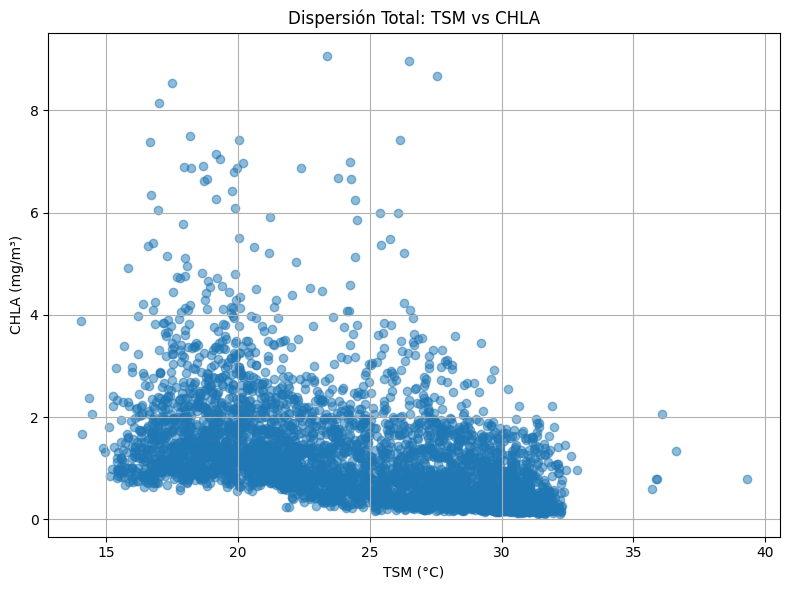

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(combined['tsm'], combined['chla'], alpha=0.5)
plt.xlabel('TSM (°C)')
plt.ylabel('CHLA (mg/m³)')
plt.title('Dispersión Total: TSM vs CHLA')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Gráficos de dispersión por evento

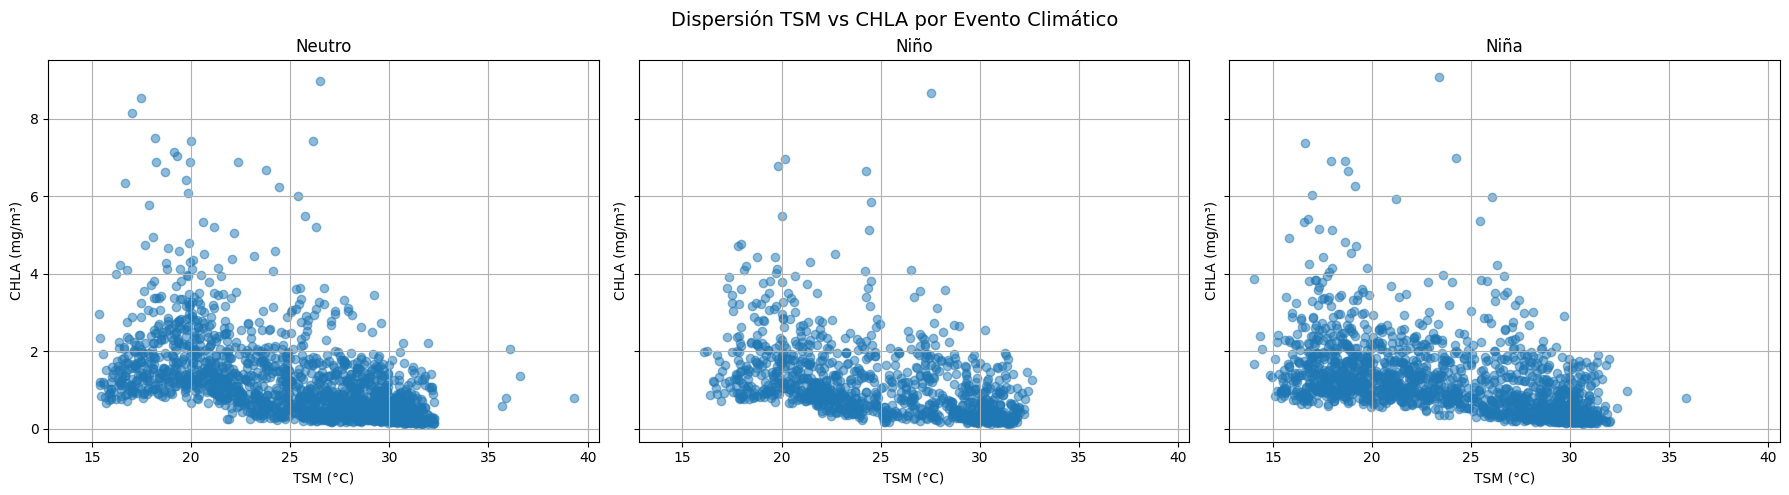

In [21]:
# Crear subplots: uno por evento
fig, axes = plt.subplots(nrows=1, ncols=len(combined['evento'].unique()), figsize=(18, 5), sharex=True, sharey=True)

# Graficar cada evento
for ax, evento in zip(axes, combined['evento'].unique()):
    subset = combined[combined['evento'] == evento]
    ax.scatter(subset['tsm'], subset['chla'], alpha=0.5)
    ax.set_title(f'{evento}')
    ax.set_xlabel('TSM (°C)')
    ax.set_ylabel('CHLA (mg/m³)')
    ax.grid(True)

fig.suptitle('Dispersión TSM vs CHLA por Evento Climático', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)


### Correlación TSM vs CHLA por estación

Después de analizar la relación general entre TSM y CHLA por tipo de evento, el siguiente paso es evaluar la **correlación entre estas variables en cada estación geográfica**.

Este análisis más detallado permite:

- Identificar qué estaciones presentan relaciones más fuertes o débiles entre TSM y CHLA
- Evaluar posibles patrones espaciales de correlación
- Determinar si ciertas zonas del área de estudio son más sensibles a la interacción entre temperatura y productividad

La correlación se calculará utilizando el coeficiente de **Pearson** sobre los valores disponibles por estación.


In [22]:
combined_valid = combined.dropna(subset=['tsm', 'chla'])

# Lista de estaciones únicas
estaciones = sorted(combined_valid['estacion'].dropna().unique())

# Diccionario para guardar correlaciones
correlaciones_ambos = {}

# Calcular correlación TSM vs CHLA por estación
for est in estaciones:
    subset = combined_valid[combined_valid['estacion'] == est]
    if not subset.empty:
        corr = subset[['tsm', 'chla']].corr().iloc[0, 1]
        correlaciones_ambos[est] = round(corr, 3)

# Convertir a DataFrame y quitar índice
correlacion_por_estacion_df = pd.DataFrame([
    {'estacion': k, 'correlacion_tsm_chla': v}
    for k, v in correlaciones_ambos.items()
])


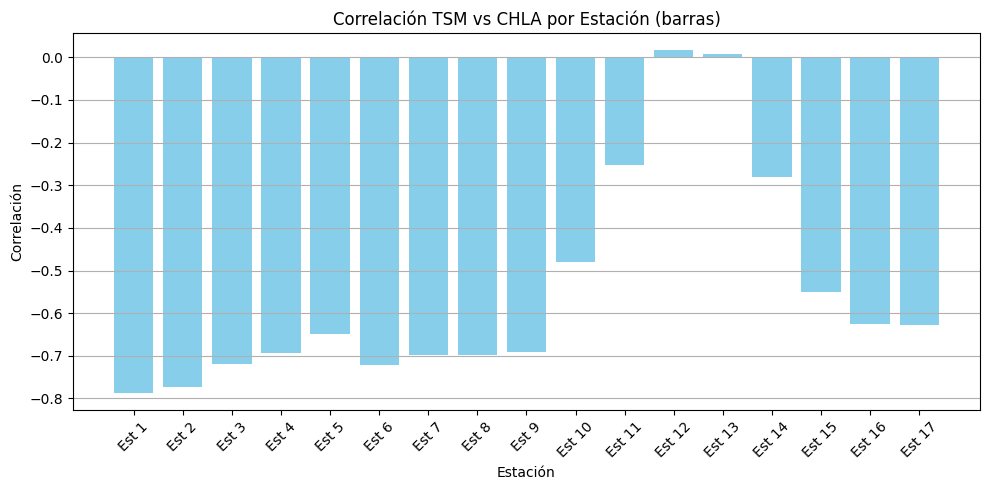

In [23]:
correlacion_por_estacion_df['est_num'] = correlacion_por_estacion_df['estacion'].str.extract(r'est_(\d+)')[0].astype(int)

# 2. Ordenar por número de estación
correlacion_por_estacion_df = correlacion_por_estacion_df.sort_values('est_num')

# 3. Crear etiquetas personalizadas: Est 1, Est 2, ...
correlacion_por_estacion_df['etiqueta'] = 'Est ' + correlacion_por_estacion_df['est_num'].astype(str)

# 4. Graficar barras
plt.figure(figsize=(10, 5))
plt.bar(
    correlacion_por_estacion_df['etiqueta'],
    correlacion_por_estacion_df['correlacion_tsm_chla'],
    color='skyblue'
)
plt.title('Correlación TSM vs CHLA por Estación (barras)')
plt.xlabel('Estación')
plt.ylabel('Correlación')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Análisis del comportamiento por estación en la correlación TSM vs CHLA

El gráfico de barras muestra la correlación de Pearson entre la Temperatura Superficial del Mar (TSM) y la Clorofila (CHLA) para cada una de las 17 estaciones.

En general, se observa un **comportamiento consistentemente negativo**, lo cual indica que a mayor temperatura superficial, tiende a disminuir la concentración de clorofila. Esto es coherente con el comportamiento típico de sistemas oceánicos donde el aumento de temperatura reduce el afloramiento de nutrientes y, por tanto, la productividad.

Sin embargo, hay algunas estaciones que presentan un **comportamiento atípico**:

- **Estación 12 y Estación 13** muestran correlaciones cercanas a cero o incluso levemente positivas. Esto sugiere que en estas ubicaciones específicas, la relación TSM–CHLA no sigue la tendencia general del resto del área.
- Estas anomalías pueden deberse a:
  - Influencias locales distintas (corrientes, batimetría, intrusión de masas de agua diferentes)
  - Posibles errores o inconsistencias en los datos registrados en esas estaciones
  - Menor cantidad de datos disponibles o mayor variabilidad interna

Este comportamiento sugiere que debe hacerse una **evaluación espacial más detallada**, considerando la ubicación geográfica y las condiciones oceanográficas particulares de cada estación.


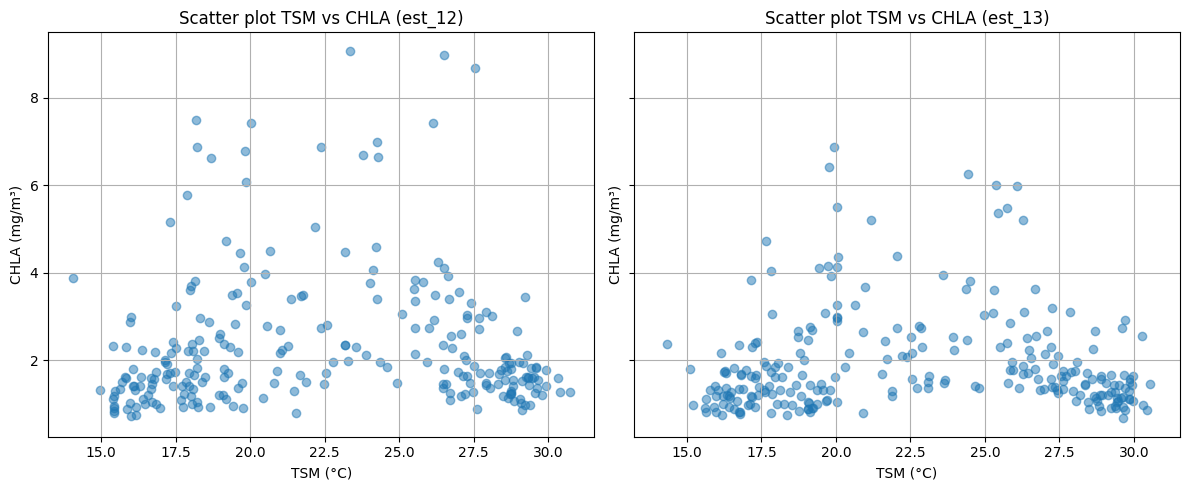

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

for i, est in enumerate([f"est_{i}" for i in range(12, 14)]):
    subset = combined[combined["estacion"] == est]
    axes[i].scatter(subset["tsm"], subset["chla"], alpha=0.5)
    axes[i].set_title(f"Scatter plot TSM vs CHLA ({est})")
    axes[i].set_xlabel("TSM (°C)")
    axes[i].set_ylabel("CHLA (mg/m³)")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

## Análisis mensual

Realizaremos un análisis más detallado a nivel **mensual**.

Este enfoque nos permitirá:

- Observar la evolución de **TSM** y **CHLA** mes a mes a lo largo del año
- Detectar **patrones estacionales finos**, como máximos o mínimos en meses específicos
- Comparar cómo varían las condiciones del océano según el **evento ENSO** dentro de cada mes

El análisis se realizará agrupando los datos por **número de mes** (`mes_num`), permitiendo posteriormente visualizar las tendencias anuales y evaluar diferencias entre eventos climáticos.



In [25]:
# Crear columna 'mes' si no existe
combined['mes'] = combined['fecha'].dt.month

# Crear función para mapear mes a estación
def mes_a_estacion(mes):
    if mes in [12, 1, 2]:
        return 'DJF'
    elif mes in [3, 4, 5]:
        return 'MAM'
    elif mes in [6, 7, 8]:
        return 'JJA'
    elif mes in [9, 10, 11]:
        return 'SON'

# Aplicar la función
combined['estacion_climatica'] = combined['mes'].apply(mes_a_estacion)


### Frecuencia mensual de eventos ENSO

Visualizaremos la **frecuencia de ocurrencia de cada tipo de evento ENSO** (`Niño`, `Niña`, `Neutro`) a lo largo del año.

Este análisis tiene como objetivo:

- Determinar en qué meses se presentan con mayor frecuencia los distintos eventos
- Evaluar si existe una **estacionalidad** en la aparición de fenómenos ENSO
- Comprender mejor el contexto temporal de los datos, lo cual es clave al interpretar las variaciones mensuales de TSM y CHLA

La visualización se realizará mediante un gráfico de barras agrupado por mes, diferenciando los eventos mediante color.


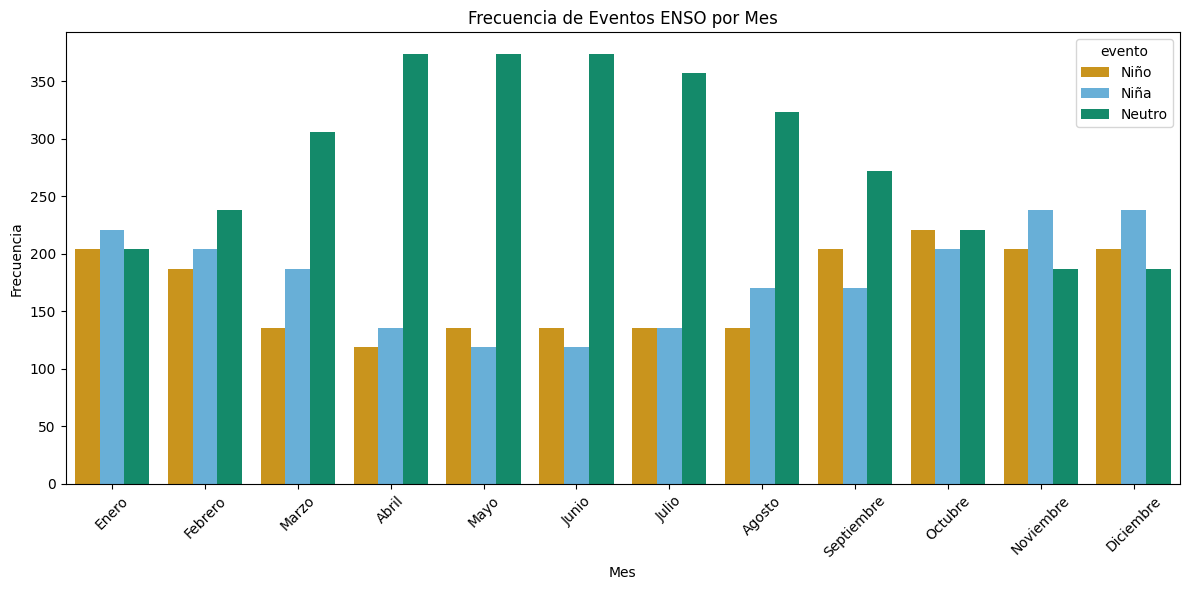

In [26]:
df1 = combined.copy()
meses_es = {
    1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril',
    5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto',
    9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
}
df1['mes'] = df1['mes'].map(meses_es)
evento_por_mes = df1.groupby(['mes', 'evento']).size().reset_index(name='frecuencia')
orden_meses = list(meses_es.values())
evento_por_mes['mes'] = pd.Categorical(evento_por_mes['mes'], categories=orden_meses, ordered=True)
evento_por_mes = evento_por_mes.sort_values('mes')

# Colores accesibles para daltónicos
colores_daltonicos = {
    'Niño': '#E69F00',
    'Niña': '#56B4E9',
    'Neutro': '#009E73'
}

# Gráfico
plt.figure(figsize=(12, 6))
sns.barplot(
    data=evento_por_mes,
    x='mes',
    y='frecuencia',
    hue='evento',
    palette=colores_daltonicos
)
plt.title('Frecuencia de Eventos ENSO por Mes')
plt.xlabel('Mes')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Análisis de la frecuencia mensual de eventos ENSO

El gráfico de barras muestra la cantidad de veces que ocurrieron los eventos climáticos **Niño**, **Niña** y **Neutro** en cada mes del año a lo largo del período analizado.

#### Observaciones clave:

- El evento **Neutro** es el más frecuente en la mayoría de los meses, especialmente de **abril a julio**, donde supera ampliamente a Niño y Niña. Esto sugiere que las condiciones neutrales son dominantes durante la primera mitad del año.
- En los meses de **marzo a agosto**, la presencia de eventos **Niño y Niña disminuye**, lo cual coincide con la transición estacional hacia condiciones más estables en el océano Pacífico.
- A partir de **septiembre y hasta febrero**, se observa un aumento progresivo en la frecuencia de **Niño** y **Niña**, con picos en **noviembre y diciembre**. Esto es consistente con el ciclo estacional típico del ENSO, que tiende a intensificarse hacia finales del año.

#### Conclusión:

Existe una **estacionalidad clara** en la ocurrencia de eventos ENSO. Esta información es útil para interpretar las variaciones mensuales de TSM y CHLA, ya que la presencia de Niño o Niña en ciertos meses puede explicar comportamientos anómalos en la temperatura o productividad del mar.


In [27]:
def mes_a_estacion(m):
    if m in [12, 1, 2]:
        return 'DJF'
    elif m in [3, 4, 5]:
        return 'MAM'
    elif m in [6, 7, 8]:
        return 'JJA'
    elif m in [9, 10, 11]:
        return 'SON'

df['mes'] = df['fecha'].dt.month
mensual_evento = df.groupby(['mes', 'evento'])[['tsm', 'chla']].mean().round(3).reset_index()
mensual_evento['estacion_climatica'] = mensual_evento['mes'].apply(mes_a_estacion)
estacional_evento = mensual_evento.groupby(['estacion_climatica', 'evento'])[['tsm', 'chla']].mean().round(3).reset_index()
tsm_mensual = mensual_evento.pivot(index='mes', columns='evento', values='tsm')
chla_mensual = mensual_evento.pivot(index='mes', columns='evento', values='chla')

### Promedios mensuales de TSM y CHLA por tipo de evento

A continuación, graficaremos los **valores promedio mensuales** de **TSM** y **CHLA** desglosados por tipo de evento ENSO: **Niño**, **Niña** y **Neutro**.

Este análisis nos permitirá:

- Observar cómo varía la temperatura superficial del mar y la concentración de clorofila a lo largo del año en función del evento climático.
- Comparar visualmente las diferencias entre condiciones cálidas (Niño), frías (Niña) y normales (Neutro).
- Detectar patrones estacionales específicos que puedan estar influenciados por la fase del ENSO.

Las gráficas mostrarán las tendencias mensuales agrupadas por evento, permitiendo identificar meses particularmente sensibles a cada fenómeno.


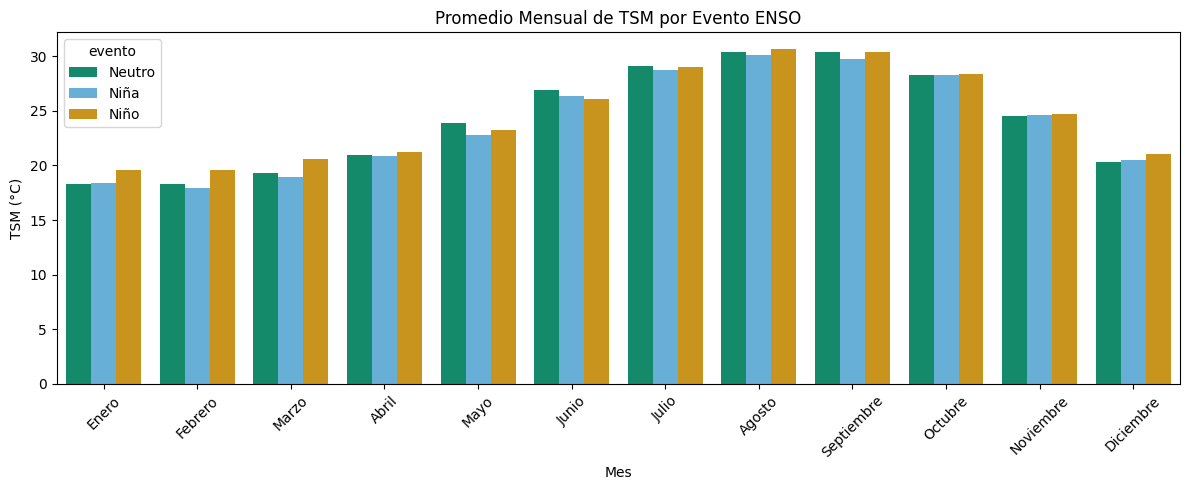

In [28]:
# Convertir mes numérico a nombre
meses_es = {
    1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril',
    5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto',
    9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
}

# Agregar columna con nombre de mes
mensual_evento['mes_nombre'] = mensual_evento['mes'].map(meses_es)
orden_meses = list(meses_es.values())
mensual_evento['mes_nombre'] = pd.Categorical(mensual_evento['mes_nombre'], categories=orden_meses, ordered=True)

# Paleta accesible para personas con daltonismo
colores_daltonicos = {
    'Niño': '#E69F00',
    'Niña': '#56B4E9',
    'Neutro': '#009E73'
}

# Gráfico
plt.figure(figsize=(12, 5))
sns.barplot(data=mensual_evento, x='mes_nombre', y='tsm', hue='evento', palette=colores_daltonicos)
plt.title('Promedio Mensual de TSM por Evento ENSO')
plt.xlabel('Mes')
plt.ylabel('TSM (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Análisis del promedio mensual de TSM por evento ENSO

La gráfica muestra la evolución mensual del **promedio de la Temperatura Superficial del Mar (TSM)** diferenciada por tipo de evento ENSO: **Niño**, **Niña** y **Neutro**.

### Observaciones destacadas:

- Durante los meses de **invierno y primavera** (enero a mayo), el evento **Niño presenta sistemáticamente temperaturas más altas** que Niña y Neutro, lo cual es coherente con su impacto conocido en el calentamiento del océano.
- En los meses **más cálidos del año (junio a septiembre)**, las diferencias entre los eventos se **reducen considerablemente**, mostrando una convergencia de los valores de TSM independientemente del evento.
- En **octubre y noviembre**, las diferencias vuelven a ser mínimas, pero en **diciembre** se observa nuevamente una ligera separación con **Niño superando a los demás**.
- El evento **Niña tiende a presentar las TSM más bajas** en casi todos los meses, especialmente en el primer semestre del año.

#### Conclusión:

El evento ENSO influye con mayor claridad en los meses **de transición y comienzo del año (enero–mayo)**, donde las diferencias entre Niño, Niña y Neutro en TSM son más notables. Durante el **verano y principios del otoño**, la influencia parece menos marcada, posiblemente por el dominio de factores locales como la radiación solar y la estratificación térmica.


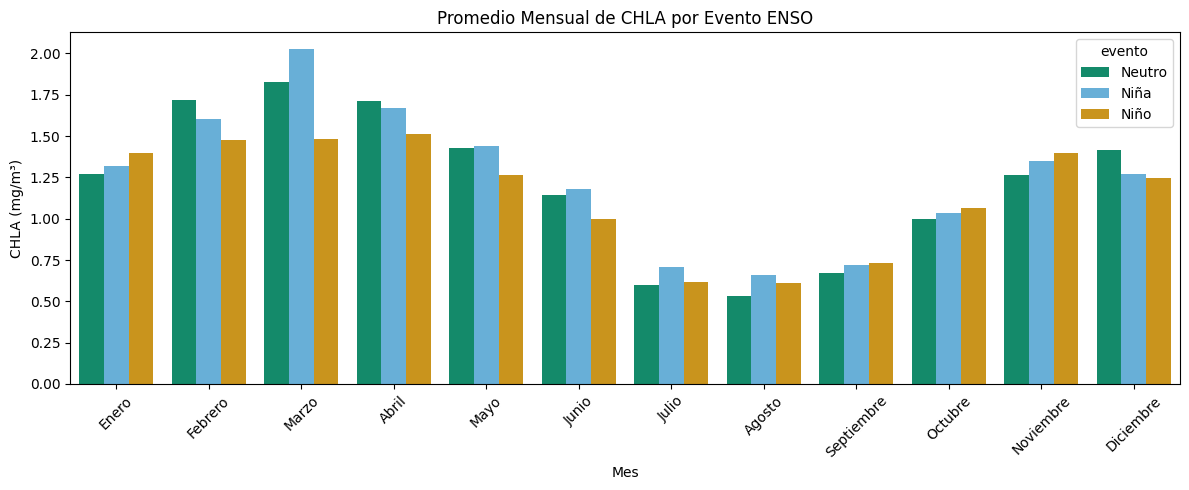

In [29]:
# CHLA
plt.figure(figsize=(12, 5))
sns.barplot(data=mensual_evento, x='mes_nombre', y='chla', hue='evento', palette=colores_daltonicos)
plt.title('Promedio Mensual de CHLA por Evento ENSO')
plt.xlabel('Mes')
plt.ylabel('CHLA (mg/m³)')
plt.xticks(rotation=45)
plt.tight_layout()


### Análisis del promedio mensual de CHLA por evento ENSO

La gráfica presenta los **promedios mensuales de concentración de clorofila (CHLA)** para cada tipo de evento ENSO: **Niño**, **Niña** y **Neutro**.

### Observaciones clave:

- Durante los primeros meses del año (**enero a abril**), se observa una mayor concentración de CHLA bajo condiciones **Niña**, con un **pico en marzo** que supera los 2.0 mg/m³, evidenciando una alta productividad oceánica durante este periodo.
- El evento **Niño** se asocia a menores concentraciones de CHLA, en especial entre **febrero y junio**, lo que coincide con su efecto inhibidor sobre el afloramiento de nutrientes.
- Entre **julio y septiembre**, los niveles de CHLA son bajos en general para todos los eventos, con valores por debajo de 1.0 mg/m³, lo que sugiere una etapa de baja productividad estacional.
- A partir de **octubre y hasta diciembre**, las diferencias entre eventos se reducen, aunque **Neutro y Niño** tienden a registrar niveles ligeramente más altos que Niña.

#### Conclusión:

Los eventos **Niña favorecen mayores concentraciones de clorofila**, especialmente en los primeros meses del año, lo cual refleja un aumento en la productividad biológica del mar durante condiciones frías. Por el contrario, **El Niño se asocia a una disminución general de la CHLA**, en línea con sus efectos sobre la dinámica oceánica y el transporte de nutrientes.


## Análisis por estación climática

Después de estudiar el analisis de la frecuencia mensual, el siguiente paso consiste en analizar estas variables en función de las **estaciones climáticas**:

- **DJF**: Diciembre, Enero, Febrero  
- **MAM**: Marzo, Abril, Mayo  
- **JJA**: Junio, Julio, Agosto  
- **SON**: Septiembre, Octubre, Noviembre

Este análisis nos permitirá:

- Evaluar patrones **sazonales** en la temperatura y la productividad del océano
- Identificar períodos del año con mayor o menor variabilidad
- Explorar cómo se comportan TSM y CHLA a lo largo del ciclo anual, de forma independiente del evento ENSO

Utilizaremos agrupaciones por `estacion_climatica` para calcular estadísticas descriptivas y comparaciones entre periodos.

In [30]:
resumen_temporada = combined.groupby('estacion_climatica')[['tsm', 'chla']].agg(
    ['mean', 'std', 'min', 'max', 'count']
).round(3)

resumen_temporada


tsm                                chla                \
                      mean    std     min     max count   mean    std    min   
estacion_climatica                                                             
DJF                 19.307  2.437  10.369  26.925  1887  1.408  0.742  0.264   
JJA                 28.659  2.107  17.717  39.300  1887  0.786  0.821  0.110   
MAM                 21.350  2.759  13.633  36.075  1887  1.640  1.260  0.163   
SON                 27.746  2.886  14.433  35.689  1921  1.025  0.925  0.110   

                                 
                      max count  
estacion_climatica               
DJF                 5.414  1071  
JJA                 8.968  1071  
MAM                 8.528  1071  
SON                 9.068  1105

In [31]:
# Paso 1: Crear columna mes
df['mes'] = df['fecha'].dt.month

# Paso 2: Calcular promedios mensuales de TSM y CHLA por evento
mensual_evento = df.groupby(['mes', 'evento'])[['tsm', 'chla']].mean().round(3).reset_index()

# Paso 3: Asignar estación climática según el mes
def mes_a_estacion(m):
    if m in [12, 1, 2]:
        return 'DJF'
    elif m in [3, 4, 5]:
        return 'MAM'
    elif m in [6, 7, 8]:
        return 'JJA'
    elif m in [9, 10, 11]:
        return 'SON'

mensual_evento['estacion_climatica'] = mensual_evento['mes'].apply(mes_a_estacion)

# Paso 4: Agrupar por estación climática y evento
estacional_evento = mensual_evento.groupby(['estacion_climatica', 'evento'])[['tsm', 'chla']].mean().round(3).reset_index()

# Paso 5: Pivot para tener columnas por evento
tsm_est = estacional_evento.pivot(index='estacion_climatica', columns='evento', values='tsm')
chla_est = estacional_evento.pivot(index='estacion_climatica', columns='evento', values='chla')

# Paso 6: Calcular diferencias Niño - Niña
tsm_est_diff = (tsm_est['Niño'] - tsm_est['Niña']).round(3)
chla_est_diff = (chla_est['Niña'] - chla_est['Niño']).round(3)

# Paso 7: Crear DataFrame final
diferencias_estacionales = pd.DataFrame({
    'tsm_Niño_menos_Niña': tsm_est_diff,
    'chla_Niña_menos_Niño': chla_est_diff
})

diferencias_estacionales

,tsm_Niño_menos_Niña,chla_Niña_menos_Niño
estacion_climatica,,
DJF,1.161,0.025
JJA,0.161,0.107
MAM,0.806,0.294
SON,0.282,-0.025


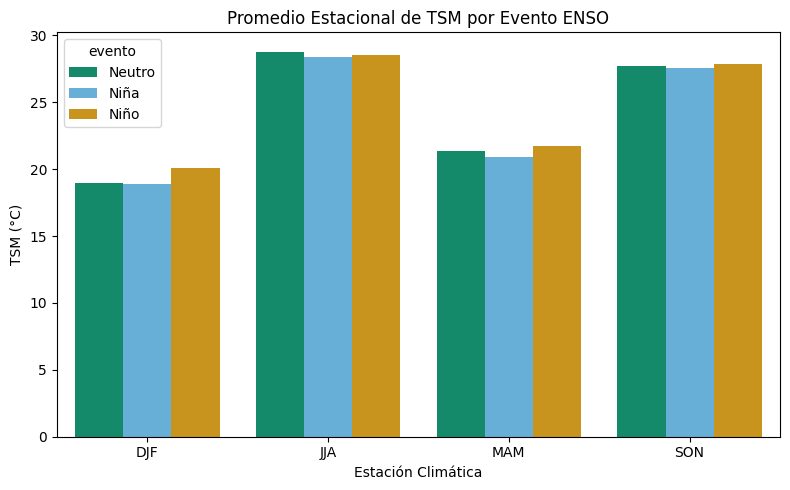

In [32]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=estacional_evento,
    x='estacion_climatica',
    y='tsm',
    hue='evento',
    palette=colores_daltonicos
)
plt.title('Promedio Estacional de TSM por Evento ENSO')
plt.xlabel('Estación Climática')
plt.ylabel('TSM (°C)')
plt.tight_layout()
plt.show()

In [33]:
combined.groupby('evento')[['tsm', 'chla']].describe().round(2)

tsm                                                    chla        \
         count   mean   std    min    25%    50%    75%    max   count  mean   
evento                                                                         
Neutro  3417.0  24.56  4.80  10.37  20.42  25.00  28.99  39.30  1768.0  1.20   
Niña    2142.0  23.60  4.85  13.99  19.30  23.27  28.24  35.87  1513.0  1.27   
Niño    2023.0  24.53  4.53  13.67  20.74  24.32  28.73  33.14  1037.0  1.16   

                                            
         std   min   25%   50%   75%   max  
evento                                      
Neutro  1.08  0.11  0.44  0.92  1.57  8.97  
Niña    0.96  0.13  0.65  1.05  1.67  9.07  
Niño    0.96  0.12  0.45  0.91  1.57  8.67

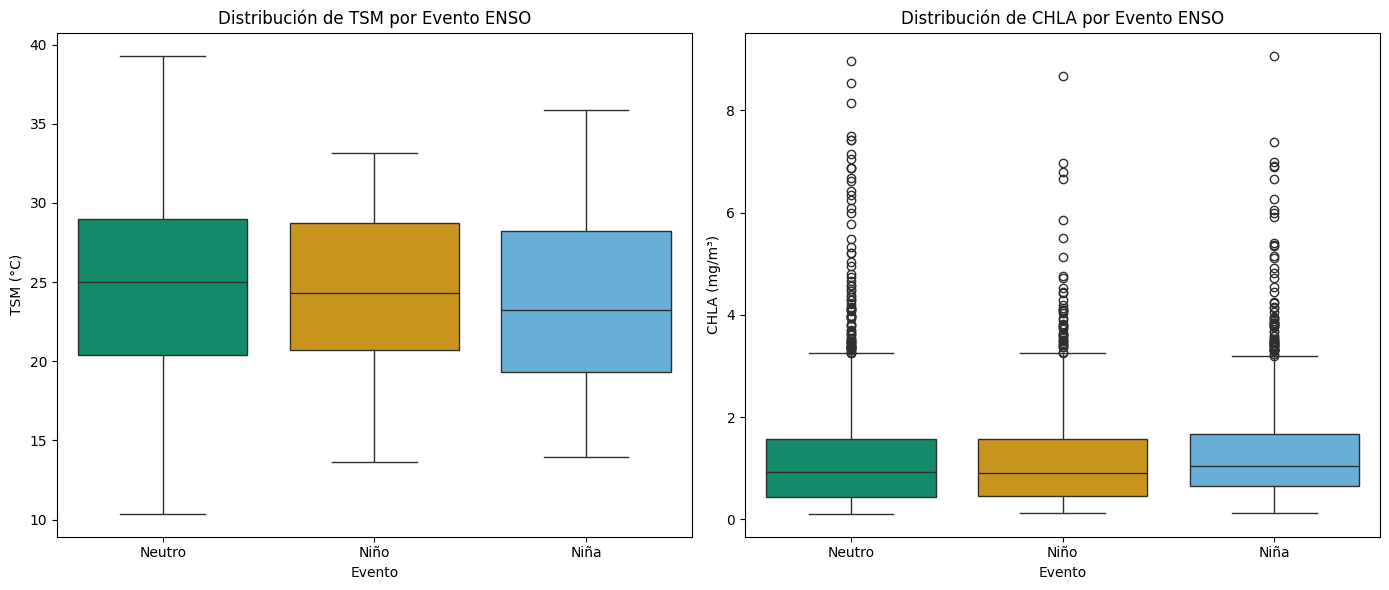

In [34]:
colores_daltonicos = {
    'Niño': '#E69F00',
    'Niña': '#56B4E9',
    'Neutro': '#009E73'
}

# Crear figura
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot de TSM con hue explícito
sns.boxplot(data=combined, x='evento', y='tsm', hue='evento', palette=colores_daltonicos, ax=axes[0], legend=False)
axes[0].set_title('Distribución de TSM por Evento ENSO')
axes[0].set_xlabel('Evento')
axes[0].set_ylabel('TSM (°C)')

# Boxplot de CHLA con hue explícito
sns.boxplot(data=combined, x='evento', y='chla', hue='evento', palette=colores_daltonicos, ax=axes[1], legend=False)
axes[1].set_title('Distribución de CHLA por Evento ENSO')
axes[1].set_xlabel('Evento')
axes[1].set_ylabel('CHLA (mg/m³)')

# Ajuste final (sin mostrar)
plt.tight_layout()

In [35]:
shapiro_resultados = {}
for evento in ['Niño', 'Niña', 'Neutro']:
    subset = df[df['evento'] == evento]
    
    tsm_values = subset['tsm'].dropna()
    chla_values = subset['chla'].dropna()
    
    stat_tsm, p_tsm = shapiro(tsm_values)
    stat_chla, p_chla = shapiro(chla_values)
    
    shapiro_resultados[evento] = {
        'p_tsm': round(p_tsm, 5),
        'tsm_normal': p_tsm > 0.05,
        'p_chla': round(p_chla, 5),
        'chla_normal': p_chla > 0.05
    }

# Mostrar resultados
for evento, resultado in shapiro_resultados.items():
    print(f"{evento}:")
    print(f"  TSM normal? {resultado['tsm_normal']} (p={resultado['p_tsm']})")
    print(f"  CHLA normal? {resultado['chla_normal']} (p={resultado['p_chla']})\n")


Niño:
  TSM normal? False (p=0.0)
  CHLA normal? False (p=0.0)

Niña:
  TSM normal? False (p=0.0)
  CHLA normal? False (p=0.0)

Neutro:
  TSM normal? False (p=0.0)
  CHLA normal? False (p=0.0)



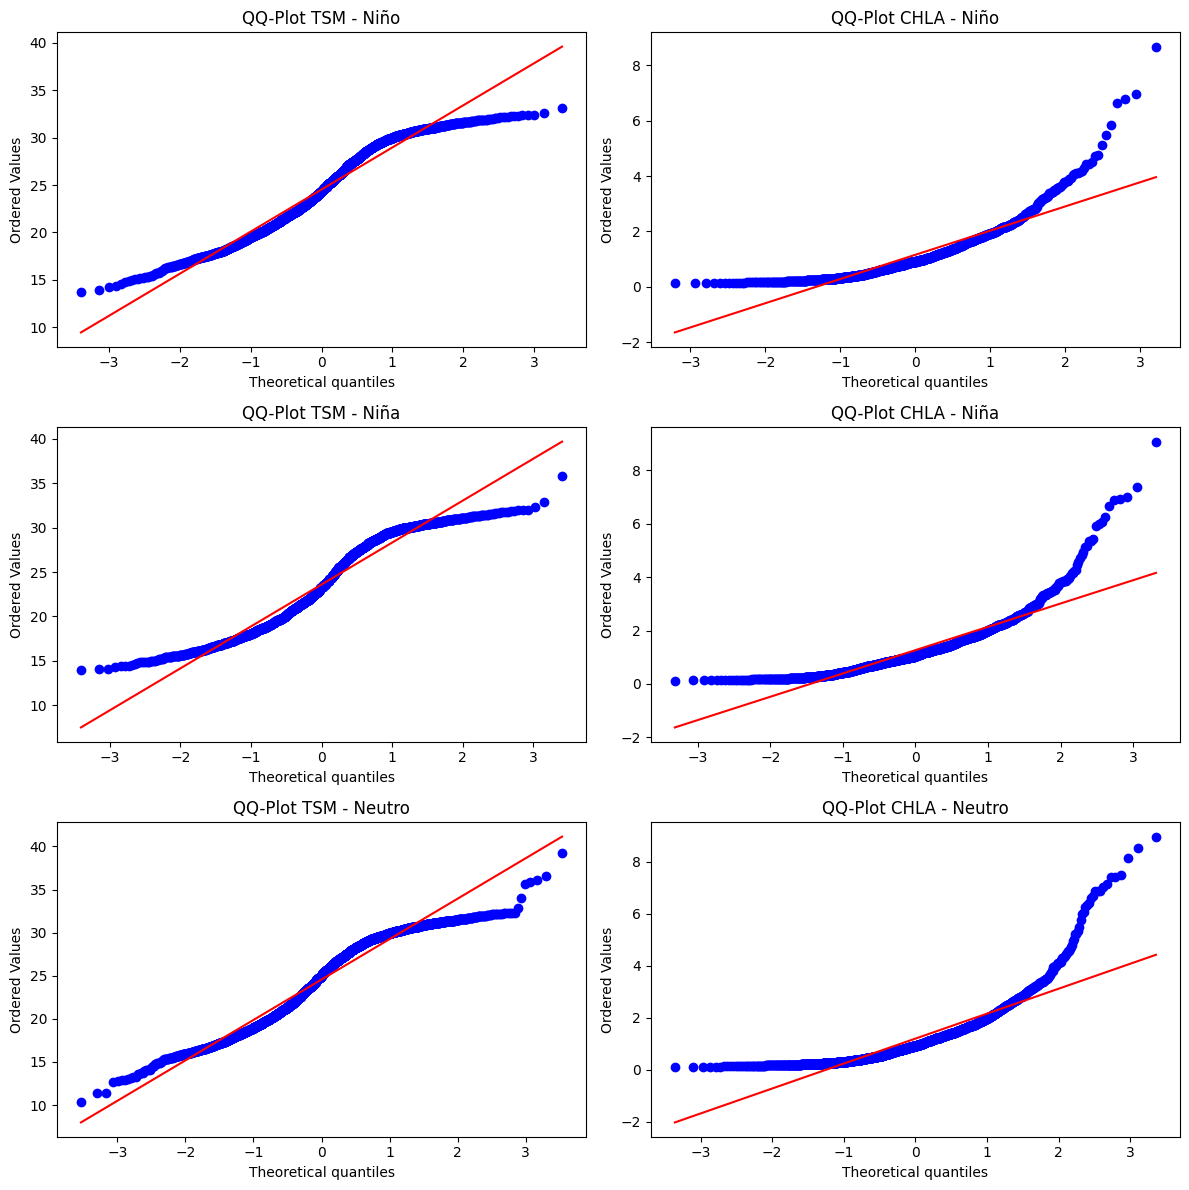

In [36]:
df['evento'] = df['evento'].replace({'Normal': 'Neutro'})

# Lista de eventos ENSO
eventos = ['Niño', 'Niña', 'Neutro']

# Crear figura con 3 filas (una por evento) y 2 columnas (TSM y CHLA)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

for i, evento in enumerate(eventos):
    subset = df[df['evento'] == evento]

    # QQ-plot para TSM
    stats.probplot(subset['tsm'].dropna(), dist="norm", plot=axes[i, 0])
    axes[i, 0].set_title(f'QQ-Plot TSM - {evento}')

    # QQ-plot para CHLA
    stats.probplot(subset['chla'].dropna(), dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f'QQ-Plot CHLA - {evento}')

plt.tight_layout()


In [37]:
grupo_tsm = [df[df['evento'] == ev]['tsm'].dropna() for ev in ['Niño', 'Niña', 'Neutro']]
kruskal_tsm = kruskal(*grupo_tsm)

# Prueba para CHLA
grupo_chla = [df[df['evento'] == ev]['chla'].dropna() for ev in ['Niño', 'Niña', 'Neutro']]
kruskal_chla = kruskal(*grupo_chla)

print("Kruskal-Wallis TSM:", kruskal_tsm)
print("Kruskal-Wallis CHLA:", kruskal_chla)

Kruskal-Wallis TSM: KruskalResult(statistic=np.float64(62.35605286077534), pvalue=np.float64(2.8810789849266625e-14))
Kruskal-Wallis CHLA: KruskalResult(statistic=np.float64(26.75923562079791), pvalue=np.float64(1.5463429368103787e-06))


## 📊 Análisis de Varianza No Paramétrico — Kruskal-Wallis

Se aplicó la prueba de **Kruskal-Wallis** para evaluar si existen diferencias estadísticamente significativas en **TSM** (Temperatura Superficial del Mar) y **CHLA** (Clorofila) entre los tres tipos de eventos ENSO: **Niño, Niña y Neutro**.

### 🔹 Resultados:

- **TSM:**
  - Estadístico H = 62.36
  - Valor p = 2.88e-14
  - ✅ *Conclusión:* Hay diferencias significativas en TSM entre al menos dos de los eventos ENSO.

- **CHLA:**
  - Estadístico H = 26.76
  - Valor p = 1.55e-06
  - ✅ *Conclusión:* También existen diferencias significativas en CHLA entre al menos dos de los eventos ENSO.


Aplicar una prueba **post-hoc** (como **Dunn's test** con corrección por comparaciones múltiples) para determinar exactamente **qué pares de eventos** son significativamente diferentes.


In [38]:
# Dunn's test para TSM
dunn_tsm = sp.posthoc_dunn(df, val_col='tsm', group_col='evento', p_adjust='bonferroni')

# Dunn's test para CHLA
dunn_chla = sp.posthoc_dunn(df, val_col='chla', group_col='evento', p_adjust='bonferroni')


In [39]:
dunn_tsm

,Neutro,Niña,Niño
Neutro,1.000000e+00,4.852285e-13,1.000000e+00
Niña,4.852285e-13,1.000000e+00,4.977123e-10
Niño,1.000000e+00,4.977123e-10,1.000000e+00


In [40]:
dunn_chla

,Neutro,Niña,Niño
Neutro,1.000000,0.025195,1.000000
Niña,0.025195,1.000000,0.049561
Niño,1.000000,0.049561,1.000000


## Prueba Post-Hoc: Dunn con Corrección de Bonferroni

Luego de confirmar diferencias significativas mediante la prueba de Kruskal-Wallis, se aplicó una **prueba post-hoc de Dunn** para determinar **entre qué pares de eventos ENSO (Niño, Niña, Neutro)** existen diferencias significativas.

Se utilizó la corrección de Bonferroni para ajustar los valores *p* por comparaciones múltiples.

---

### 🌡️ **TSM - Temperatura Superficial del Mar**

| Comparación       | p-valor     | ¿Significativa? |
|-------------------|-------------|------------------|
| Neutro vs Niña    | 4.85e-13     | ✅ Sí             |
| Neutro vs Niño    | 1.00         | ❌ No             |
| Niña vs Niño      | 4.98e-10     | ✅ Sí             |

➡ *Interpretación:*  
- La **Niña tiene TSM significativamente menor** que Niño y Neutro.
- **Niño y Neutro no difieren** significativamente en TSM.

---

### 🌿 **CHLA - Clorofila**

| Comparación       | p-valor     | ¿Significativa? |
|-------------------|-------------|------------------|
| Neutro vs Niña    | 0.0252       | ✅ Sí             |
| Neutro vs Niño    | 1.00         | ❌ No             |
| Niña vs Niño      | 0.0496       | ✅ Sí             |

➡ *Interpretación:*  
- **La Niña presenta CHLA significativamente mayor** que Niño y Neutro.
- **Niño y Neutro no presentan diferencias significativas** en CHLA.

---

### ✅ Conclusión

La **Niña se diferencia estadísticamente** de los otros eventos tanto en TSM como en CHLA, lo cual apoya la hipótesis de que **ENSO influye directamente en la temperatura y productividad del océano**.


In [41]:
# Asegurar que los índices de coordenadas coinciden con las estaciones
coordenadas = coordenadas.reset_index(drop=True).copy()
coordenadas['est_index'] = coordenadas.index
coordenadas['estacion'] = coordenadas['est_index'].apply(lambda i: f"est_{i+1}")

# Unir coordenadas con el DataFrame de promedios por estación y evento
promedios_estacion_evento = df.groupby(['estacion', 'evento'])[['tsm', 'chla']].mean().round(3).reset_index()
promedios_geo = pd.merge(promedios_estacion_evento, coordenadas, on='estacion', how='left')




In [42]:
# Asegurarse de que el DataFrame de coordenadas esté preparado
coordenadas = coordenadas.reset_index(drop=True).copy()
coordenadas['est_index'] = coordenadas.index
coordenadas['estacion'] = coordenadas['est_index'].apply(lambda i: f"est_{i+1}")

# Calcular promedios por estación y evento
promedios_estacion_evento = df.groupby(['estacion', 'evento'])[['tsm', 'chla']].mean().round(3).reset_index()

# Unir con coordenadas
promedios_geo = pd.merge(promedios_estacion_evento, coordenadas, on='estacion', how='left')

# Filtrar para El Niño
tsm_nino = promedios_geo[promedios_geo['evento'] == 'Niño'].copy()

# Crear el mapa centrado en la región de estaciones
map_center = [tsm_nino['latitud'].mean(), tsm_nino['longitud'].mean()]
m = folium.Map(location=map_center, zoom_start=6, control_scale=True)

# Agregar círculos codificados por TSM
for _, row in tsm_nino.iterrows():
    folium.CircleMarker(
        location=[row['latitud'], row['longitud']],
        radius=5 + (row['tsm'] - tsm_nino['tsm'].min()) * 2,
        color='red',
        fill=True,
        fill_opacity=0.7,
        popup=f"{row['estacion']}<br>TSM: {row['tsm']} °C"
    ).add_to(m)

# Mostrar mapa
m


In [43]:
# Filtrar para evento La Niña
chla_nina = promedios_geo[promedios_geo['evento'] == 'Niña'].copy()

# Crear mapa centrado en la región de estaciones
map_center = [chla_nina['latitud'].mean(), chla_nina['longitud'].mean()]
m = folium.Map(location=map_center, zoom_start=6, control_scale=True)

# Agregar círculos codificados por CHLA
for _, row in chla_nina.iterrows():
    folium.CircleMarker(
        location=[row['latitud'], row['longitud']],
        radius=5 + (row['chla'] - chla_nina['chla'].min()) * 5,
        color='green',
        fill=True,
        fill_opacity=0.7,
        popup=f"{row['estacion']}<br>CHLA: {row['chla']} mg/m³"
    ).add_to(m)

# Mostrar mapa
m
